# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

Business Understanding: 
From a data perspective, the task is to analyze a dataset of used car listings to identify the most important features that influence the price of a used car. This involves performing exploratory data analysis (EDA) to understand the distribution, relationships, and potential correlations among the available variables such as make, model, year, mileage, condition, and location. By employing statistical techniques like correlation analysis, feature importance ranking, and possibly machine learning algorithms such as linear regression, we aim to determine the key predictors that have the strongest impact on the price of a used car. The insights gained from this data-driven approach will provide actionable information to guide business decisions related to pricing strategies and inventory management in the used car market.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [7]:
# Import all library needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance

In [8]:
#Data Loading and Overview
data_original = pd.read_csv('data/vehicles.csv')
print("Overview information\n", data_original.info())
print("\n Statistics information\n", data_original.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

##### Missing Values Analysis:
1. Check for the presence of missing or null values in each column and calculate the percentage of missing values for each feature.
2. Determine if there are any patterns or correlations among the missing values.
3. Assess the impact of missing values on the analysis and consider appropriate handling techniques 

In [9]:
print("\nSummary of categorical features:\n")
print(data_original.describe(include='object'))


Summary of categorical features:

          region manufacturer   model condition    cylinders    fuel  \
count     426880       409234  421603    252776       249202  423867   
unique       404           42   29649         6            8       5   
top     columbus         ford   f-150      good  6 cylinders     gas   
freq        3608        70985    8009    121456        94169  356209   

       title_status transmission                VIN   drive       size  \
count        418638       424324             265838  296313     120519   
unique            6            3             118246       3          4   
top           clean    automatic  1FMJU1JT1HEA52352     4wd  full-size   
freq         405117       336524                261  131904      63465   

          type paint_color   state  
count   334022      296677  426880  
unique      13          12      51  
top      sedan       white      ca  
freq     87056       79285   50614  


In [10]:
# Check for missing values
print(">>>>Missing values:")
print((data_original.isnull().sum()/data_original.shape[0]) *100)

>>>>Missing values:
id               0.000000
region           0.000000
price            0.000000
year             0.282281
manufacturer     4.133714
model            1.236179
condition       40.785232
cylinders       41.622470
fuel             0.705819
odometer         1.030735
title_status     1.930753
transmission     0.598763
VIN             37.725356
drive           30.586347
size            71.767476
type            21.752717
paint_color     30.501078
state            0.000000
dtype: float64


Based on the data above 
1. size, drive, cylinders, conditions, VIN, paint_color could be dorpped due to high percentage of missing value and low unique values and high frequency of the top value
2. title_status , transmission could also be dropped due to the top value frequency is high and the unique value is low
3. region, model need to be drop as too many unique values and could cause overfitting 
4. id is not useful, could drop it. 

In [11]:
# Get unique values for "state"
state_unique = data_original['state'].unique()
print("Unique values for 'state':")
print(state_unique)

# Get unique values for "model"
model_unique = data_original['manufacturer'].unique()
print("\nUnique values for 'manufacturer':")
print(model_unique)

# Get unique values for "type"
type_unique = data_original['type'].unique()
print("\nUnique values for 'type':")
print(type_unique)

Unique values for 'state':
['az' 'ar' 'fl' 'ma' 'nc' 'ny' 'or' 'pa' 'tx' 'wa' 'wi' 'al' 'ak' 'ca'
 'co' 'ct' 'dc' 'de' 'ga' 'hi' 'id' 'il' 'in' 'ia' 'ks' 'ky' 'la' 'me'
 'md' 'mi' 'mn' 'ms' 'mo' 'mt' 'ne' 'nv' 'nj' 'nm' 'nh' 'nd' 'oh' 'ok'
 'ri' 'sc' 'sd' 'tn' 'ut' 'vt' 'va' 'wv' 'wy']

Unique values for 'manufacturer':
[nan 'gmc' 'chevrolet' 'toyota' 'ford' 'jeep' 'nissan' 'ram' 'mazda'
 'cadillac' 'honda' 'dodge' 'lexus' 'jaguar' 'buick' 'chrysler' 'volvo'
 'audi' 'infiniti' 'lincoln' 'alfa-romeo' 'subaru' 'acura' 'hyundai'
 'mercedes-benz' 'bmw' 'mitsubishi' 'volkswagen' 'porsche' 'kia' 'rover'
 'ferrari' 'mini' 'pontiac' 'fiat' 'tesla' 'saturn' 'mercury'
 'harley-davidson' 'datsun' 'aston-martin' 'land rover' 'morgan']

Unique values for 'type':
[nan 'pickup' 'truck' 'other' 'coupe' 'SUV' 'hatchback' 'mini-van' 'sedan'
 'offroad' 'bus' 'van' 'convertible' 'wagon']


Based on the value in manufacture and type, will fill na with "other"

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [12]:
print("\n\n###Summary of all features after data preparation:\n")
print(data.describe())
print("\n\n###Summary of categorical features after data preparation:\n")
print(data.describe(include='object'))
print("\n\n###Missing values:")
print((data.isnull().sum()/data.shape[0]) *100)



###Summary of all features after data preparation:



NameError: name 'data' is not defined

In [13]:
#drop the columns not needed based on the data understanding steps
data = data_original.drop(["size", "drive", "paint_color", "cylinders", 
           "condition", "VIN", "id", "title_status", 
           "transmission", "model", "region"], axis = 1)
data.drop(data[(data['manufacturer'].isnull()) | (data['manufacturer'] == 'other') | 
               (data['type'].isnull()) | (data['type'] == 'other')].index, inplace = True)
# Replace NaN values with 'other' in 'manufacturer' column - 
# tried this and the modeling result is worse due to bad data quality
# data['manufacturer'].fillna('other', inplace=True)

# Replace NaN values with 'other' in 'type' column
#data['type'].fillna('other', inplace=True)

In [14]:
data.drop(data[(data['year'].isnull())].index, inplace = True)
data.drop(data[(data['odometer'].isnull())].index, inplace = True)
data.drop(data[(data['fuel'].isnull())].index, inplace = True)

In [15]:
from datetime import datetime

# Convert year to age
current_year = datetime.now().year
data['age'] = current_year - data['year']

# Drop the original 'year' column 
data.drop('year', axis=1, inplace = True)

In [16]:
# Get unique values for "model"
model_unique = data['manufacturer'].unique()
print("\nUnique values for 'manufacturer':")
print(model_unique)

# Get unique values for "type"
type_unique = data['type'].unique()
print("\nUnique values for 'type':")
print(type_unique)


Unique values for 'manufacturer':
['gmc' 'chevrolet' 'toyota' 'ford' 'nissan' 'jeep' 'ram' 'cadillac'
 'honda' 'dodge' 'lexus' 'chrysler' 'volvo' 'infiniti' 'lincoln'
 'alfa-romeo' 'subaru' 'audi' 'hyundai' 'buick' 'mercedes-benz' 'bmw'
 'mitsubishi' 'acura' 'volkswagen' 'mazda' 'porsche' 'kia' 'rover'
 'ferrari' 'pontiac' 'fiat' 'mini' 'jaguar' 'tesla' 'saturn' 'mercury'
 'harley-davidson' 'datsun' 'aston-martin' 'land rover' 'morgan']

Unique values for 'type':
['pickup' 'truck' 'coupe' 'SUV' 'hatchback' 'mini-van' 'sedan' 'offroad'
 'van' 'convertible' 'wagon' 'bus']


In [17]:
# Drop rows with missing values
data = data.dropna()

In [18]:
print("\n\n###Summary of all features after data preparation:\n")
print(data.describe())
print("\n\n###Missing values:")
print((data.isnull().sum()/data.shape[0]) *100)



###Summary of all features after data preparation:

              price      odometer            age
count  2.969520e+05  2.969520e+05  296952.000000
mean   4.089252e+04  9.240028e+04      11.980805
std    7.622228e+06  1.663871e+05       8.138646
min    0.000000e+00  0.000000e+00       2.000000
25%    6.495000e+03  3.689600e+04       7.000000
50%    1.485000e+04  8.245000e+04      10.000000
75%    2.659000e+04  1.296740e+05      15.000000
max    3.736929e+09  1.000000e+07     124.000000


###Missing values:
price           0.0
manufacturer    0.0
fuel            0.0
odometer        0.0
type            0.0
state           0.0
age             0.0
dtype: float64


In [19]:
# Feature selection using SelectKBest
selector = SelectKBest(f_regression, k=5)
selector.fit(df[feature_columns], df[target_column])
selected_features = df[feature_columns].columns[selector.get_support()]
print("\nSelected Features (SelectKBest):")
print(selected_features

SyntaxError: incomplete input (2977387626.py, line 6)

In [20]:
# Function to remove outliers using IQR method
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers from each column
data = remove_outliers_iqr(data, 'price')
data = remove_outliers_iqr(data, 'odometer')
data = remove_outliers_iqr(data, 'age')

print("DataFrame with outliers removed:")
print(data.describe())

DataFrame with outliers removed:
               price       odometer            age
count  280508.000000  280508.000000  280508.000000
mean    17021.359134   88212.945371      11.004574
std     12949.102225   58261.513173       5.145521
min         0.000000       0.000000       2.000000
25%      6500.000000   37699.250000       7.000000
50%     14898.000000   83000.000000      10.000000
75%     25995.000000  129000.000000      14.000000
max     56725.000000  268434.000000      27.000000


In [21]:
# Specify the categorical columns to be encoded
categorical_columns = ['manufacturer', 'fuel', 'type', 'state']

# Perform one-hot encoding on the categorical columns
data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

# Print the updated DataFrame
print("Updated DataFrame with encoded categorical features:")
print(data.head())

# Print the summary of encoded categorical features
print("\nSummary of encoded features:")
print(data.describe())

Updated DataFrame with encoded categorical features:
    price  odometer   age  manufacturer_alfa-romeo  manufacturer_aston-martin  \
27  33590   57923.0  10.0                    False                      False   
28  22590   71229.0  14.0                    False                      False   
29  39590   19160.0   4.0                    False                      False   
30  30990   41124.0   7.0                    False                      False   
31  15000  128000.0  11.0                    False                      False   

    manufacturer_audi  manufacturer_bmw  manufacturer_buick  \
27              False             False               False   
28              False             False               False   
29              False             False               False   
30              False             False               False   
31              False             False               False   

    manufacturer_cadillac  manufacturer_chevrolet  ...  state_sd  state_tn  \
27 

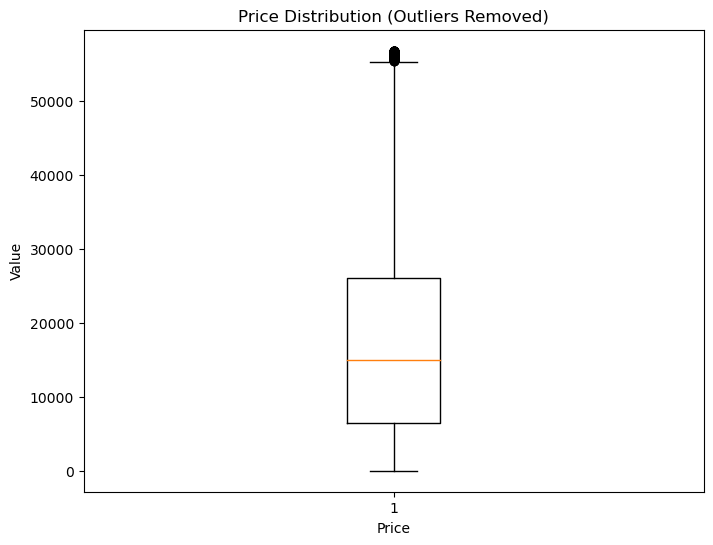

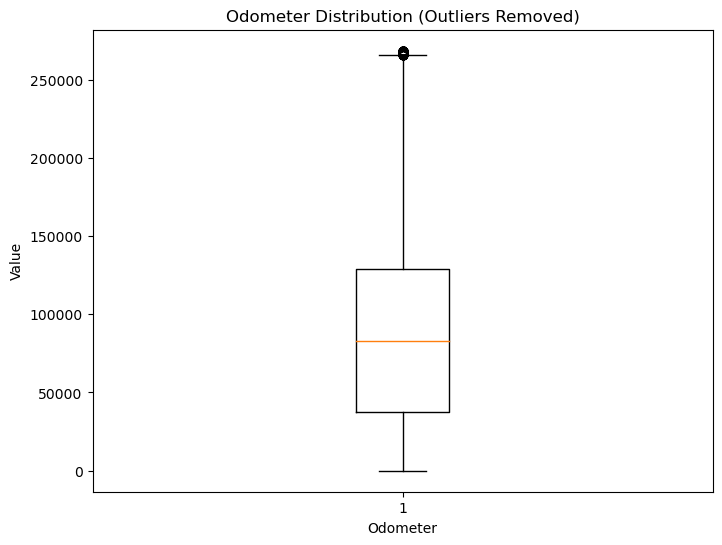

In [22]:
# Create a boxplot to visualize the 'price' column without outliers
plt.figure(figsize=(8, 6))
plt.boxplot(data['price'])
plt.title("Price Distribution (Outliers Removed)")
plt.xlabel("Price")
plt.ylabel("Value")
plt.show()

# Create a boxplot to visualize the 'odometer' column without outliers
plt.figure(figsize=(8, 6))
plt.boxplot(data['odometer'])
plt.title("Odometer Distribution (Outliers Removed)")
plt.xlabel("Odometer")
plt.ylabel("Value")
plt.show()


In [23]:
# Correlation analysis
correlation_matrix = data.corr()
print("Correlation Matrix:")
print(correlation_matrix)


Correlation Matrix:
                              price  odometer       age  \
price                      1.000000 -0.474682 -0.500063   
odometer                  -0.474682  1.000000  0.684044   
age                       -0.500063  0.684044  1.000000   
manufacturer_alfa-romeo    0.049843 -0.059944 -0.052921   
manufacturer_aston-martin  0.000586 -0.007212  0.003490   
...                             ...       ...       ...   
state_vt                  -0.000549  0.005548 -0.004501   
state_wa                   0.048240 -0.033102 -0.033026   
state_wi                  -0.002673  0.004840  0.019776   
state_wv                   0.030254 -0.011169 -0.013363   
state_wy                   0.011273  0.000379 -0.002482   

                           manufacturer_alfa-romeo  manufacturer_aston-martin  \
price                                     0.049843                   0.000586   
odometer                                 -0.059944                  -0.007212   
age                         

<Axes: >

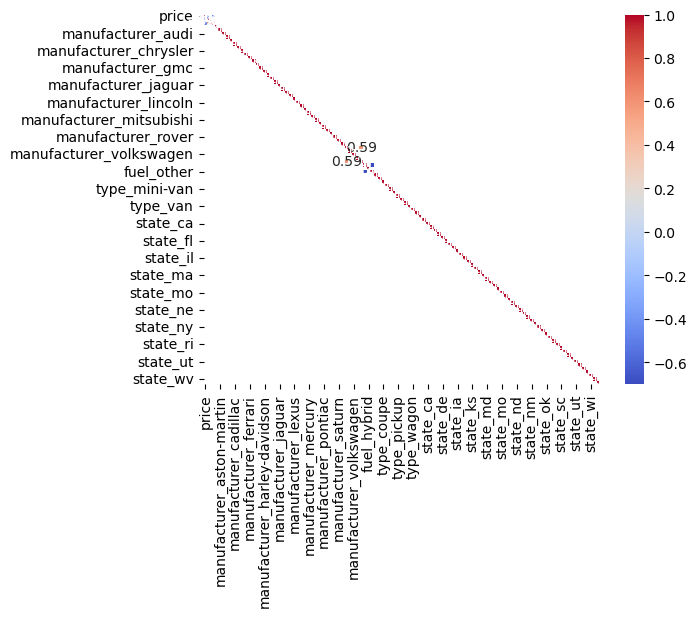

In [24]:
threshold = 0.3  # Adjust the threshold as needed
mask = np.abs(correlation_matrix) < threshold
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, mask=mask)


Covariance Matrix:
                                  price      odometer            age  \
price                      1.676792e+08 -3.581165e+08  -33319.105002   
odometer                  -3.581165e+08  3.394404e+09  205066.627311   
age                       -3.331911e+04  2.050666e+05      26.476384   
manufacturer_alfa-romeo    3.431152e+01 -1.856614e+02      -0.014476   
manufacturer_aston-martin  4.964828e-02 -2.748200e+00       0.000117   
...                                 ...           ...            ...   
state_vt                  -5.557776e-01  2.527146e+01      -0.001811   
state_wa                   1.135205e+02 -3.504813e+02      -0.030883   
state_wi                  -5.518065e+00  4.495508e+01       0.016222   
state_wv                   2.048418e+01 -3.402593e+01      -0.003595   
state_wy                   5.283789e+00  8.000481e-01      -0.000462   

                           manufacturer_alfa-romeo  manufacturer_aston-martin  \
price                             

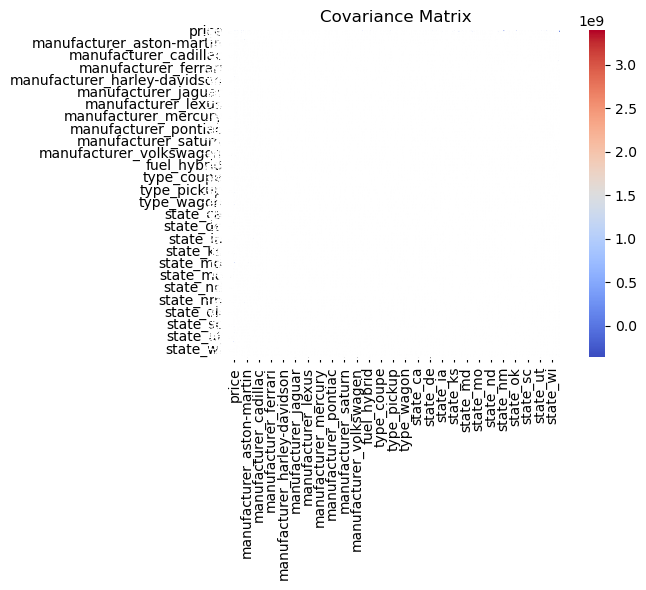

In [25]:
# Covariance analysis
covariance_matrix = data.cov()
print("\nCovariance Matrix:")
print(covariance_matrix)
# Visualize covariance matrix using heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(covariance_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Covariance Matrix')
plt.tight_layout()
plt.show()


### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [26]:
### Find the hyperparameters used for the model 

In [27]:
X = data.drop('price', axis = 1)
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the resulting sets
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (224406, 106)
Shape of y_train: (224406,)
Shape of X_test: (56102, 106)
Shape of y_test: (56102,)


This plot confirm the most important features for proce is millege, age and car brand

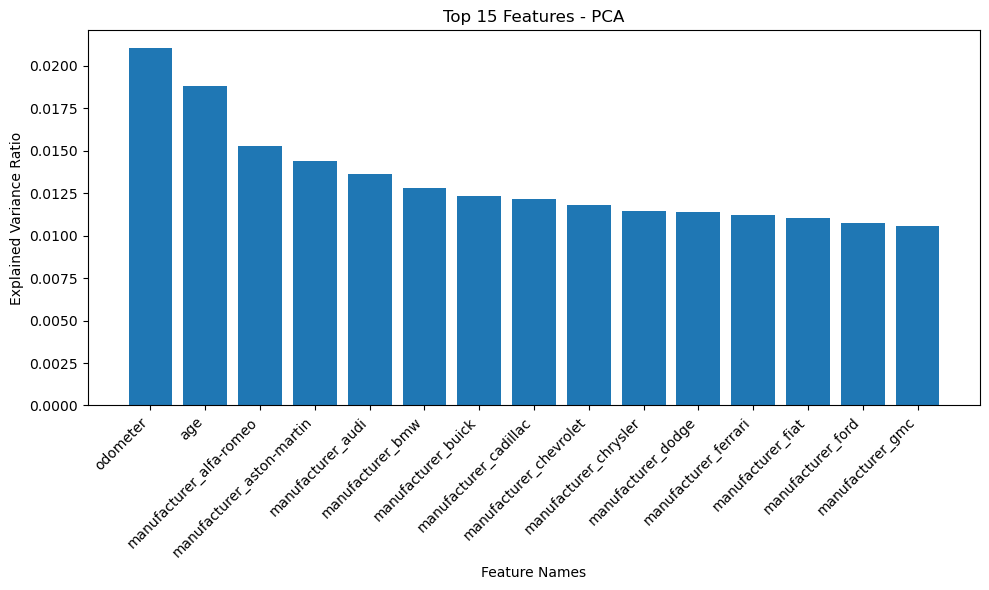

In [30]:
# Assuming you have the feature names in the columns of your X dataframe
feature_names = X.columns

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create a PCA object
pca = PCA()

# Fit PCA to the scaled features
pca.fit(X_scaled)

# Get the explained variance ratio for each component
explained_variance_ratio = pca.explained_variance_ratio_

# Get the top 15 features based on their contribution to explained variance
top_features = 15
top_feature_indices = np.argsort(explained_variance_ratio)[::-1][:top_features]
top_feature_variances = explained_variance_ratio[top_feature_indices]

# Get the corresponding feature names
top_feature_names = [feature_names[idx] for idx in top_feature_indices]

# Plot the top 15 features and their explained variance ratios
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(range(top_features), top_feature_variances)
ax.set_xticks(range(top_features))
ax.set_xticklabels(top_feature_names, rotation=45, ha='right')
ax.set_xlabel('Feature Names')
ax.set_ylabel('Explained Variance Ratio')
ax.set_title(f'Top {top_features} Features - PCA')
plt.tight_layout()
plt.show()

### Build model. Due to computation limitation on my laptop, have to use the simple model, tried to build mor ecomplext model, but it could not complete after wait for more than 12 hours and my laptop could not be used for nomal work

In [31]:
# Perform Ridge Regression
ridge_param_dict = {'ridge__alpha': [11.0, 12, 13]}
ridge_pipe = Pipeline([('scaler', MinMaxScaler()), 
                      ('ridge', Ridge())])
ridge_grid = GridSearchCV(ridge_pipe, param_grid=ridge_param_dict)
ridge_grid.fit(X_train, y_train)
ridge_train_preds = ridge_grid.predict(X_train)
ridge_test_preds = ridge_grid.predict(X_test)
ridge_train_mse = mean_squared_error(y_train, ridge_train_preds)
ridge_test_mse = mean_squared_error(y_test, ridge_test_preds)

print(f'Train MSE: {ridge_train_mse}')
print(f'Test MSE: {ridge_test_mse}')
ridge_pipe

Train MSE: 87505793.78679347
Test MSE: 87428077.59185508


Pipeline(steps=[('scaler', MinMaxScaler()), ('ridge', Ridge())])

Mean Squared Error (MSE): 87428077.59185508
Mean Absolute Error (MAE): 6519.819821761076
R-squared (R2): 0.47489880748712576


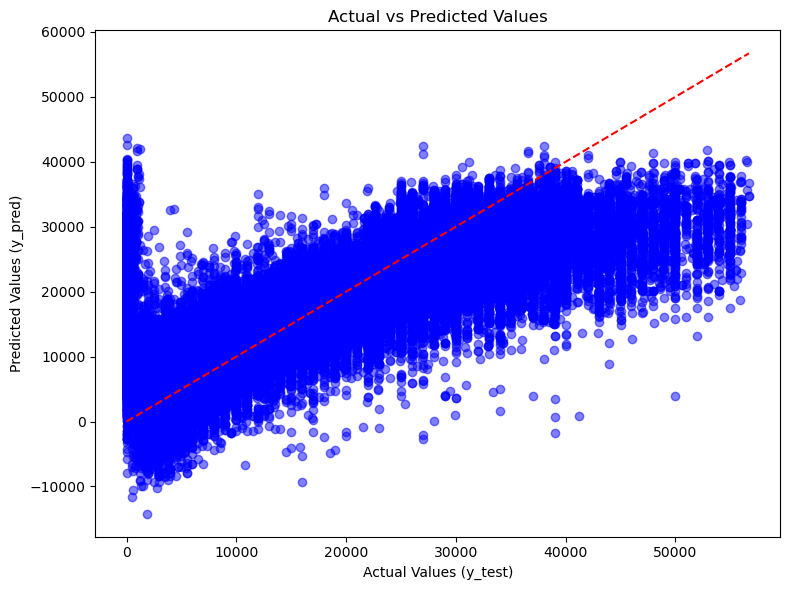

In [32]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Get the best model from the grid search
best_ridge_model = ridge_grid.best_estimator_

# Make predictions on the test set
y_pred = best_ridge_model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2):", r2)

# Create a scatter plot of y_test vs y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values (y_pred)')
plt.title('Actual vs Predicted Values')
plt.tight_layout()
plt.show()

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

Ridge Regression Model: A Ridge regression model with hyperparameter tuning was employed to address potential multicollinearity.
    #1: The best hyperparameter (alpha) value was determined using GridSearchCV.
    #2: The model achieved an R-squared value of 0.4749, indicating that it could explain approximately 47.5% of the variance in the target variable (price).
    #3: The Mean Squared Error (MSE) was 87417142.18, and the Mean Absolute Error (MAE) was 6520.27, suggesting that the model's predictions deviated from the actual values by a considerable amount.
    #4: Feature Importance: The top 10 most important features influencing the price were: age, type_pickup, odometer, fuel_gas, type_truck, state_ca, state_or, type_sedan, manufacturer_ford, and manufacturer_nissan. The age of the vehicle, its mileage, fuel type, vehicle type, and manufacturer appeared to be the strongest drivers of used car prices.

Limitations and Recommendations: While the Ridge regression model provided some insights into the factors influencing used car prices, there were several limitations:

    #1: The relatively low R-squared value indicated that there were other important variables or complex interactions not fully accounted for in the current model.
    #2: The high MSE and MAE suggested that the model's predictions could deviate substantially from actual prices for individual instances.

To improve the model's performance and predictive power, the following recommendations were made:
    #1: Using more advanced modeling techniques, Hyperparameter Tuning, Cross-Validation. I have tried this path, however, due to the limitation of computation resources, it took too long, and I had to kill the process since I needed to use the laptop for work.
    #2: Feature engineering: I have tried to create new features by combining multiple related columns together, but the modeling result did not improve significantly, so I did not continue this path.
    #3: Better handling of outlier data: I have tried a few methods, but the result was not positive, so I decided to drop the outliers and was able to achieve slightly better accuracy with the same model.
    #4: Using domain knowledge to collect more data: The current dataset is missing some critical information, such as fuel efficiency and the car accident history.
    

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.